<a href="https://colab.research.google.com/github/ShannonH98/PyTorch_Practice_Projects/blob/main/MRI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [2]:
import os
import numpy as np
import random #to get random values for data aumentation
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [3]:
!pip install kaggle

In [4]:
import os

os.environ["KAGGLE_API_TOKEN"] = "KGAT_52fddb516f9208194dc39c7e55d41f9d"

In [9]:
import json

# Save token in the format Kaggle expects
kaggle_config = {
    "username": "YOUR_KAGGLE_USERNAME",  # replace with your Kaggle username
    "key": os.environ["KAGGLE_API_TOKEN"]
}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_config, f)

!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 1.42GB/s]
100% 149M/149M [00:00<00:00, 1.32GB/s]


In [11]:
!mkdir -p /content/drive/MyDrive/mri_data
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/drive/MyDrive/mri_data


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 1.42GB/s]
100% 149M/149M [00:00<00:00, 1.33GB/s]


In [12]:
!unzip /content/drive/MyDrive/mri_data/brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/mri_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: 

In [14]:
!ls drive/MyDrive/mri_data

brain-tumor-mri-dataset.zip  Testing  Training


In [16]:
print(os.listdir("/content"))

['.config', 'drive', 'brain-tumor-mri-dataset.zip', 'sample_data']


In [17]:

train_dir = '/content/drive/MyDrive/mri_data/Training'
test_dir = '/content/drive/MyDrive/mri_data/Testing'

In [18]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  print(label)

glioma
pituitary
meningioma
notumor


In [19]:
for label in os.listdir(train_dir):
  for image in os.listdir(train_dir + '/' + label):
    train_paths.append(train_dir + '/' + label + '/' + image)
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

train_paths

['/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_1386.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_1035.jpg',
 '/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_1313.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0143.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0771.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0852.jpg',
 '/content/drive/MyDrive/mri_data/Training/notumor/Tr-no_0761.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_1020.jpg',
 '/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0082.jpg',
 '/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0738.jpg',
 '/content/drive/MyDrive/mri_data/Training/glioma/Tr-gl_0542.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0445.jpg',
 '/content/drive/MyDrive/mri_data/Training/pituitary/Tr-pi_0366.jpg',
 '/content/drive/MyDrive/mri_data/Training/meningioma/Tr-me_0805.jpg',
 '/content/drive/MyDrive/mri_data

In [20]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  print(label)

glioma
pituitary
meningioma
notumor


In [21]:
for label in os.listdir(test_dir):
  for image in os.listdir(test_dir + '/' + label):
    test_paths.append(test_dir + '/' + label + '/' + image)
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

test_paths

['/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0292.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0051.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0257.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0261.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0130.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0290.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0079.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0186.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningioma/Te-me_0043.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0113.jpg',
 '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0236.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0085.jpg',
 '/content/drive/MyDrive/mri_data/Testing/notumor/Te-no_0176.jpg',
 '/content/drive/MyDrive/mri_data/Testing/pituitary/Te-pi_0248.jpg',
 '/content/drive/MyDrive/mri_data/Testing/meningi

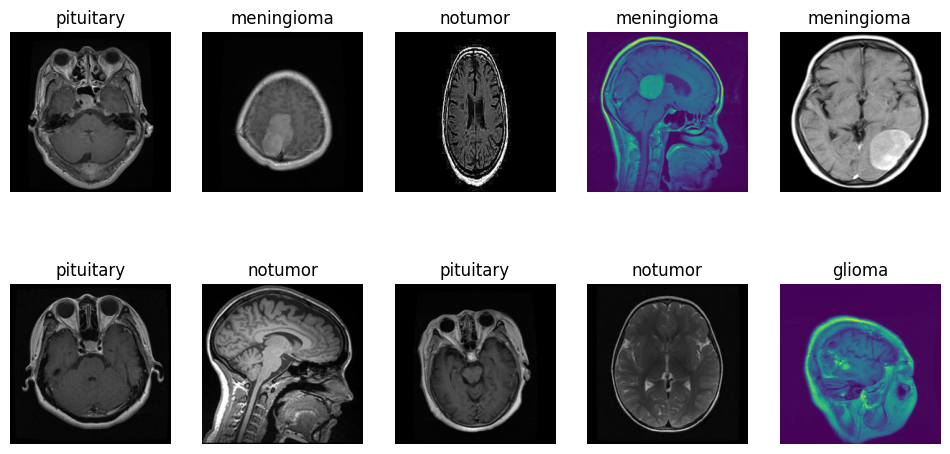

In [22]:
import random
import matplotlib.pyplot as plt

#random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

#create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#loop through the random indices and display images
for i, idx in enumerate(random_indices):
  img = load_img(train_paths[idx])
  img = Image.open(train_paths[idx])
  img = img.resize((224, 224))
  axes[i].imshow(img)
  axes[i].set_title(train_labels[idx])
  axes[i].axis('off')

In [23]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [24]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False


base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1344s 5s/step - loss: 0.6538 - sparse_categorical_accuracy: 0.7341
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1309s 5s/step - loss: 0.2521 - sparse_categorical_accuracy: 0.9042
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1325s 5s/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9423
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1331s 5s/step - loss: 0.1469 - sparse_categorical_accuracy: 0.9415
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1328s 5s/step - loss: 0.0881 - sparse_categorical_accuracy: 0.9691


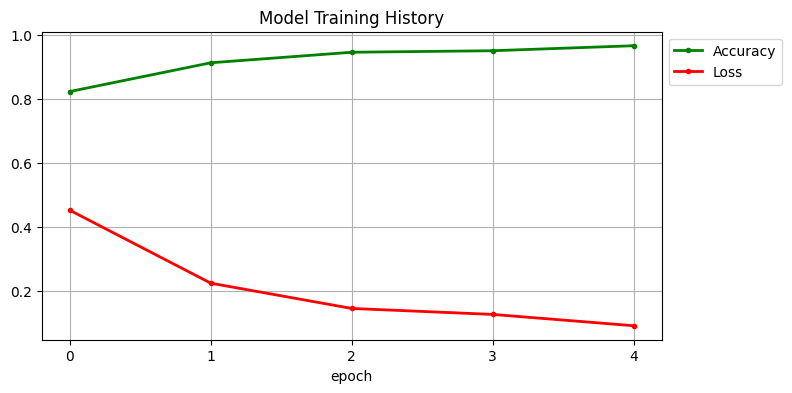

In [25]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       300
           1       0.96      0.99      0.98       300
           2       0.89      0.92      0.91       306
           3       0.98      1.00      0.99       405

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix:
[[268   1  31   0]
 [  0 296   3   1]
 [  8  10 282   6]
 [  2   0   0 403]]


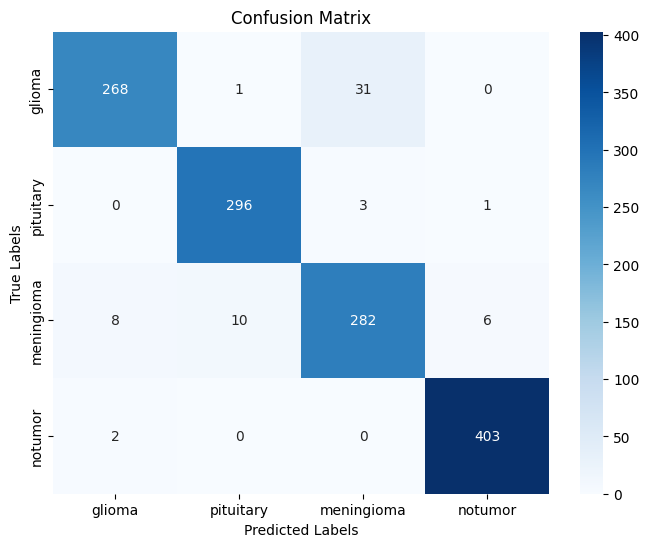

In [27]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

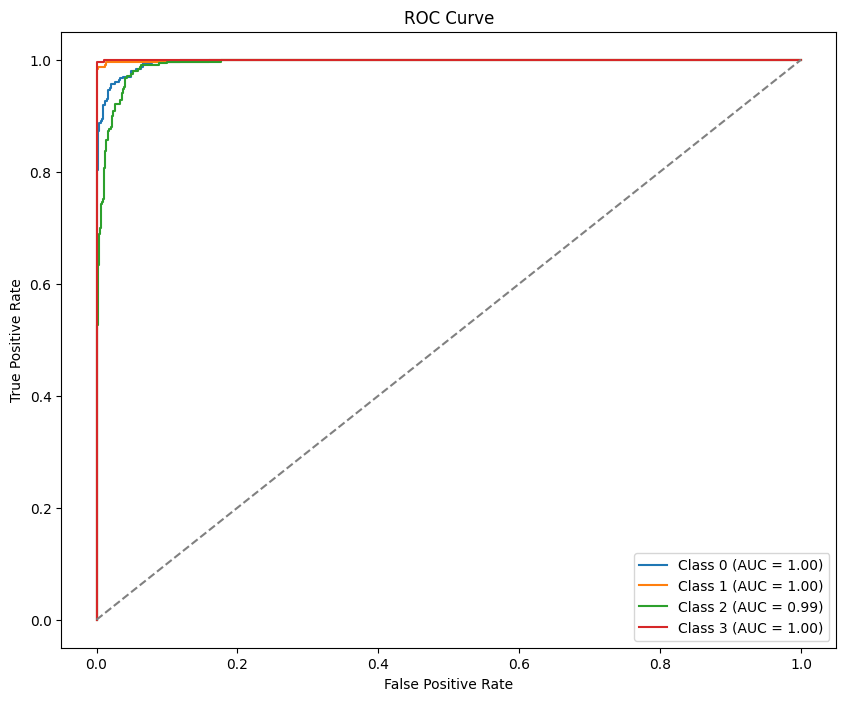

In [28]:


test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [33]:
# Save the entire model
model.save('model.keras')

In [34]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [106]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma','pituitary', 'meningioma', 'notumor']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [108]:
#get sample image path

!ls /content/drive/MyDrive/mri_data/Testing/glioma
#!ls /content/drive/MyDrive/mri_data/Testing/pituitary/
#!ls /content/drive/MyDrive/mri_data/Testing/notumor/
#pick one

Te-gl_0010.jpg	Te-gl_0085.jpg	Te-gl_0160.jpg	Te-gl_0235.jpg
Te-gl_0011.jpg	Te-gl_0086.jpg	Te-gl_0161.jpg	Te-gl_0236.jpg
Te-gl_0012.jpg	Te-gl_0087.jpg	Te-gl_0162.jpg	Te-gl_0237.jpg
Te-gl_0013.jpg	Te-gl_0088.jpg	Te-gl_0163.jpg	Te-gl_0238.jpg
Te-gl_0014.jpg	Te-gl_0089.jpg	Te-gl_0164.jpg	Te-gl_0239.jpg
Te-gl_0015.jpg	Te-gl_0090.jpg	Te-gl_0165.jpg	Te-gl_0240.jpg
Te-gl_0016.jpg	Te-gl_0091.jpg	Te-gl_0166.jpg	Te-gl_0241.jpg
Te-gl_0017.jpg	Te-gl_0092.jpg	Te-gl_0167.jpg	Te-gl_0242.jpg
Te-gl_0018.jpg	Te-gl_0093.jpg	Te-gl_0168.jpg	Te-gl_0243.jpg
Te-gl_0019.jpg	Te-gl_0094.jpg	Te-gl_0169.jpg	Te-gl_0244.jpg
Te-gl_0020.jpg	Te-gl_0095.jpg	Te-gl_0170.jpg	Te-gl_0245.jpg
Te-gl_0021.jpg	Te-gl_0096.jpg	Te-gl_0171.jpg	Te-gl_0246.jpg
Te-gl_0022.jpg	Te-gl_0097.jpg	Te-gl_0172.jpg	Te-gl_0247.jpg
Te-gl_0023.jpg	Te-gl_0098.jpg	Te-gl_0173.jpg	Te-gl_0248.jpg
Te-gl_0024.jpg	Te-gl_0099.jpg	Te-gl_0174.jpg	Te-gl_0249.jpg
Te-gl_0025.jpg	Te-gl_0100.jpg	Te-gl_0175.jpg	Te-gl_0250.jpg
Te-gl_0026.jpg	Te-gl_0101.jpg	Te-gl_0176

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


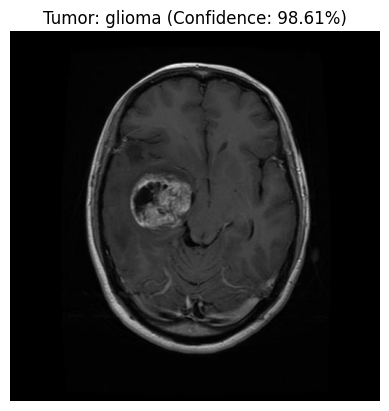

In [109]:
image_path = '/content/drive/MyDrive/mri_data/Testing/glioma/Te-gl_0028.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)